<a href="https://colab.research.google.com/github/gitirom/ImagClassification-CNN-/blob/main/Multi_Img_Classification_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/andrewmvd/animal-faces")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: wadiabenromdhane
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/andrewmvd/animal-faces


100%|██████████| 696M/696M [00:11<00:00, 65.2MB/s]


KGAT_cd55c30a50296a24a27fd2b639d467ac//aeza5zKi4
wadiabenromdhane

In [26]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms #make a preproccessing on images
from torch.utils.data import DataLoader, Dataset
from torchsummary import summary
from sklearn.preprocessing import LabelEncoder
from PIL import Image   #read images
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device Available:", device)

Device Available: cuda


In [27]:
#loop on the file and access the content this when you want to make your own split

image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq"):
  print(i)
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    print(label)
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      print(image)
      break
    break
  break



train
dog
pixabay_dog_002108.jpg


In [28]:
image_path = []
labels = []

for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for image in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{image}")
      labels.append(label)

data_df = pd.DataFrame(zip(image_path, labels), columns=["image_path", "labels"])

data_df.head()



,image_path,labels
0,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
1,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
2,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
3,/content/animal-faces/afhq/train/dog/pixabay_d...,dog
4,/content/animal-faces/afhq/train/dog/pixabay_d...,dog


In [29]:
data_df['labels'].unique()

array(['dog', 'wild', 'cat'], dtype=object)

| Method             | Comes From   |
| ------------------ | ------------ |
| `.sample()`        | Pandas       |
| `train_test_split` | scikit-learn |

| Method             | Purpose                            |
| ------------------ | ---------------------------------- |
| `.sample()`        | General random row selection       |
| `train_test_split` | Dedicated dataset splitting for ML |


In [30]:
#split data into 3 parts using sample
train = data_df.sample(frac=0.7, random_state=42)     #randomly selects 70% of the rows
test = data_df.drop(train.index)         #Remaining 30% becomes TEMP

val = test.sample(frac=0.5, random_state=42)    #Split TEMP into VAL (15%) and TEST (15%)
test = test.drop(val.index)         #Remaining half → 15% → test


print(train.shape)
print(val.shape)
print(test.shape)






(11291, 2)
(2420, 2)
(2419, 2)


**✅ Use .sample() when:**

You want a quick custom split

**✅ Use train_test_split when:**
You want stratified sampling
(important when the target classes are imbalanced)

***==> when your dataset is imbalanced, you should avoid using .sample() for splitting.***

In [31]:
data_df['labels'].value_counts()

,count
labels,
cat,5653
dog,5239
wild,5238


In [32]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df['labels'])

#make some preproccess on the images inside a compose list
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomRotation(10), # Randomly rotate by up to 10 degrees
    transforms.RandomHorizontalFlip(), # Randomly flip the image horizontally
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # Randomly change brightness, contrast, saturation, and hue
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float)
])

📌 How augmentation reduces overfitting
🔥 Without Augmentation:

Model sees SAME images → memorizes → large train/val gap.

🔥 With Augmentation:

Model sees SLIGHTLY DIFFERENT images every epoch:

New colors

New orientations

New positions

This forces the network to learn general patterns like:

edges

shapes

textures

object structure

Which improves validation accuracy and reduces overfitting.

In [33]:
#create a custom PyTorch dataset

class CustomImageDataset(Dataset):
  def __init__(self, dataframe, transform=None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = torch.tensor(label_encoder.transform(dataframe['labels'])).to(device)


  def __len__(self):
    return self.dataframe.shape[0]

  def __getitem__(self, idx):
    image_path = self.dataframe.iloc[idx, 0]
    label = self.labels[idx]

    image = Image.open(image_path).convert("RGB")

    if self.transform:
      image = self.transform(image).to(device)

    return image, label



In [34]:
train_dataset = CustomImageDataset(dataframe=train, transform=transform)
val_dataset = CustomImageDataset(dataframe=val, transform=transform)
test_dataset = CustomImageDataset(dataframe=test, transform=transform)

In [35]:
train_dataset.__getitem__(2)

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]], device='cuda:0'),
 tensor(0, device='cuda:0'))

In [36]:
label_encoder.inverse_transform([1])   #inverse the encoded target

array(['dog'], dtype=object)

| Part                             | Action                        |
| -------------------------------- | ----------------------------- |
| `data_df.sample(n=1)`            | pick a random row             |
| `['image_path']`                 | extract the image path column |
| `.iloc[0]`                       | get the string path           |
| `Image.open(...).convert("RGB")` | load the image as RGB         |


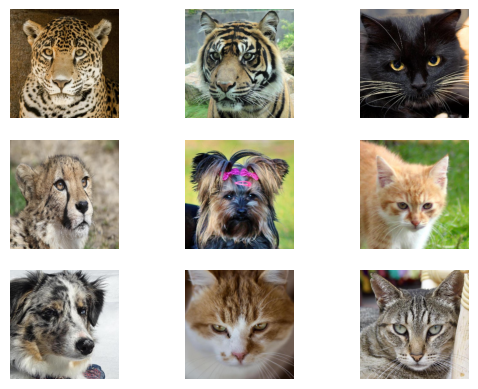

In [37]:
#visualize the images
n_rows = 3
n_cols = 3

f, axarr = plt.subplots(n_rows, n_cols)

for row in range(n_rows):
  for col in range(n_cols):
    image = Image.open(data_df.sample(n = 1)['image_path'].iloc[0]).convert("RGB") #select a random image from df
    axarr[row, col].imshow(image)
    axarr[row, col].axis('off')

plt.show()



In [46]:
#setup the hyper params
LR = 0.001
BATCH_SIZE = 32   #Larger batches = more stable gradients, faster training or 64
EPOCHS = 50

In [47]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

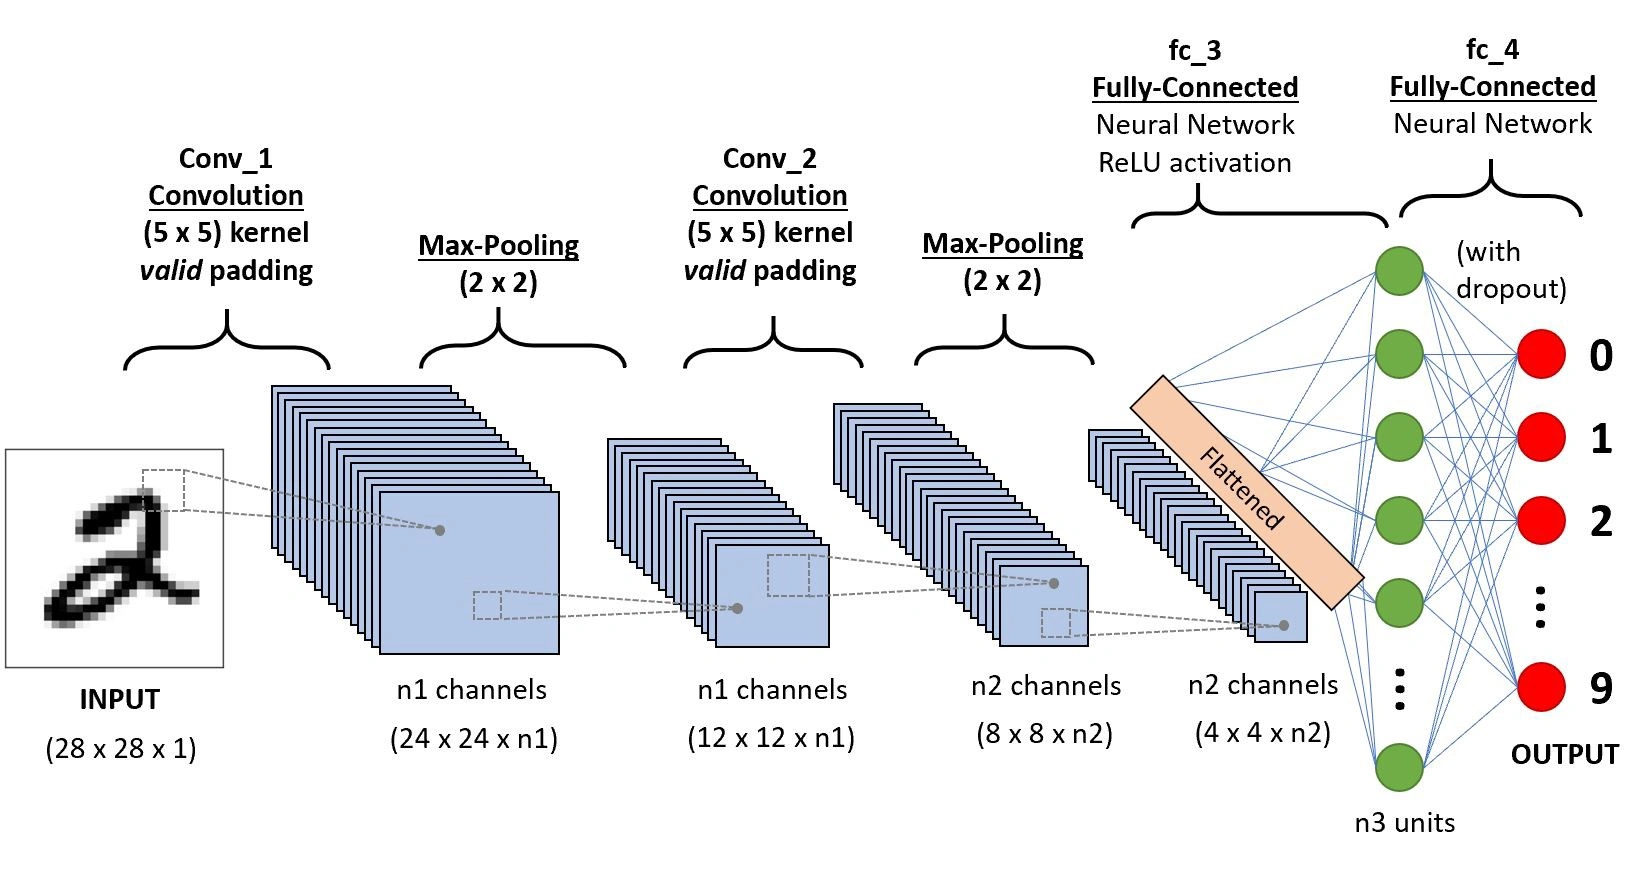

# ✅ CNN Layer-by-Layer Explanation (Corrected & Clean Version)

---

## 1️⃣ Conv1 (First Convolution Layer)
- Learns simple patterns: **edges, corners, color transitions**  
- **MaxPooling** reduces the image size and keeps important features.

---

## 2️⃣ Conv2 (Second Convolution Layer)
- Learns more complex patterns: **fur texture, eye shapes, nose curves**  
- **MaxPooling** again reduces size and keeps strongest features.

---

## 3️⃣ Conv3
- Detects animal parts: **ears, mouth, whiskers, eyes, paws**  
- No pooling or sometimes pooling depending on architecture.

---

## 4️⃣ Conv4
- Detects the full animal structure: **full cat face, dog face, lion silhouette, etc.**

---

## 5️⃣ Flatten
- Converts the 3D feature maps (**H × W × Channels**)  
  into a 1D vector so a normal neural network can process it.

---

## 6️⃣ Fully Connected Layer + ReLU
- Learns high-level combinations:  
  *“these features together mean cat/dog/wild animal”*  
- **ReLU** adds non-linearity.

---

## 7️⃣ Output Layer
- **Softmax** over 3 neurons:  
  - Cat  
  - Dog  
  - Wild  
- Outputs the **final probability and predicted class**.


⭐ Simple Summary
Dropout = randomly shutting off neurons

Purpose = reduce overfitting

Placement = after dense layers (and sometimes conv layers)

Effect = better generalization + better validation accuracy

In [48]:

#build the model
class Net(nn.Module):
  def __init__(self):
    super().__init__()

    #build the CNN layers
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

    self.pooling = nn.MaxPool2d(2, 2)

    self.relu = nn.ReLU()

    #Dropout Layers
    self.dropout_conv = nn.Dropout(0.2)      # small dropout after convs
    self.dropout_fc = nn.Dropout(0.5)        # larger dropout before FC)

    self.flatten = nn.Flatten()
    # Correcting the input features for the linear layer based on the error message
    self.linear = nn.Linear(128 * 16 * 16, 128) # 128 * 16 * 16 = 25088

    self.output = nn.Linear(128, len(data_df['labels'].unique()))

  def forward(self, x):
    x = self.conv1(x)       # (32, 128, 128)
    x = self.pooling(x)     # (32, 64, 64)
    x = self.relu(x)
    x = self.dropout_conv(x)

    x = self.conv2(x)       # (64, 64, 64)
    x = self.pooling(x)     # (64, 32, 32)
    x = self.relu(x)
    x = self.dropout_conv(x)

    x = self.conv3(x)       # (128, 32, 32)
    x = self.pooling(x)     # (128, 16, 16)
    x = self.relu(x)
    x = self.dropout_conv(x)

    x = self.flatten(x)
    x = self.linear(x)
    x = self.relu(x)
    x = self.dropout_fc(x)  # only once here
    x = self.output(x)
    return x

In [49]:
model = Net().to(device)

In [50]:
# Make a summary
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
              ReLU-3           [-1, 32, 64, 64]               0
           Dropout-4           [-1, 32, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          18,496
         MaxPool2d-6           [-1, 64, 32, 32]               0
              ReLU-7           [-1, 64, 32, 32]               0
           Dropout-8           [-1, 64, 32, 32]               0
            Conv2d-9          [-1, 128, 32, 32]          73,856
        MaxPool2d-10          [-1, 128, 16, 16]               0
             ReLU-11          [-1, 128, 16, 16]               0
          Dropout-12          [-1, 128, 16, 16]               0
          Flatten-13                [-1, 32768]               0
           Linear-14                  [

# tests automatically which batch size works.

In [40]:
# Try different batch sizes and see which works
BATCH_SIZES_TO_TRY = [16, 32, 64]

for bs in BATCH_SIZES_TO_TRY:
    try:
        train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
        # Run one batch to test
        inputs, labels = next(iter(train_loader))
        outputs = model(inputs)
        print(f"Batch size {bs}: ✓ Works!")
    except RuntimeError as e:
        print(f"Batch size {bs}: ✗ Out of memory")

Batch size 16: ✓ Works!
Batch size 32: ✓ Works!
Batch size 64: ✓ Works!


3. Why use Dropout + Weight Decay together?

You already added Dropout → Prevents co-adaptation of neurons

Adding weight_decay → Keeps weights small and reduces overfitting in a different way

🔥 Bonus: How To Choose LR Automatically

Use a learning rate finder method or try these: **How fast should the model learn?**
| Model type     | Good LR     |
| -------------- | ----------- |
| CNNs           | 1e-3 → 1e-4 |
| Transformers   | 5e-5 → 3e-4 |
| RNNs           | 1e-3        |
| SGD optimizers | 1e-2 → 1e-1 |


In [51]:
#define loss and optimizer

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=LR, weight_decay=1e-4)


In [52]:
#trainig loop

total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []    #for visualisation

for epoch in range(EPOCHS):
  total_acc_train = 0
  total_loss_train = 0
  total_loss_val = 0
  total_acc_val = 0

  for inputs, labels in train_loader:
    optimizer.zero_grad()

    outputs = model(inputs)
    train_loss = criterion(outputs, labels)
    total_loss_train += train_loss.item()

    train_loss.backward()

    train_acc = (torch.argmax(outputs, axis = 1) == labels).sum().item()
    print((torch.argmax(outputs, axis=1) == labels))

    print((torch.argmax(outputs, axis=1) == labels).sum().item())
    break
  break






tensor([False,  True, False, False, False,  True, False, False,  True, False,
        False, False, False,  True,  True,  True,  True,  True, False, False,
         True,  True, False, False, False, False,  True, False, False, False,
        False, False], device='cuda:0')
11


patience=5 → wait 5 epochs before stopping

min_delta=0.001 → minimal improvement required

👉 Epoch = one full pass of the dataset

👉 We need many epochs because learning is iterative

👉 More epochs → more learning → better accuracy (up to a point)


**Dropout** is used to **prevent your model from memorizing** (overfitting) during **training**. Generalizes better



So if patience = 5:

*   The model can go 5 consecutive epochs without improvement in validation loss
*   On the 6th epoch without improvement, training stops



In [53]:
total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

best_val_loss = float('inf')
patience = 5
patience_counter = 0


for epoch in range(EPOCHS):

    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0

    model.train()   #Enable dropout and batch norm training behavior

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        train_loss = criterion(outputs, labels)

        total_loss_train += train_loss.item()
        train_loss.backward()


        train_acc = (outputs.argmax(1) == labels).sum().item()
        total_acc_train += train_acc
        optimizer.step()

    model.eval()    #Disable dropout for validation

    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            val_acc = (outputs.argmax(1) == labels).sum().item()
            total_acc_val += val_acc

    avg_train_loss = total_loss_train / len(train_loader)
    avg_val_loss = total_loss_val / len(val_loader)
    avg_train_acc = (total_acc_train / len(train_dataset)) * 100
    avg_val_acc = (total_acc_val / len(val_dataset)) * 100

    # Plot data
    total_loss_train_plot.append(round(avg_train_loss, 4))
    total_loss_validation_plot.append(round(avg_val_loss, 4))
    total_acc_train_plot.append(round(avg_train_acc, 4))
    total_acc_validation_plot.append(round(avg_val_acc, 4))

    print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.2f}%')
    print(f'                       Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.2f}%')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pth')
        print("✓ New best model saved!")
    else:
        patience_counter += 1
        print(f"No improvement. Patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
          print(f"Early stopping triggered at epoch {epoch+1}!")
          break


    print("="*70)






Epoch 1/50, Train Loss: 0.7973, Train Acc: 61.67%
                       Val Loss: 0.4931, Val Acc: 81.40%
✓ New best model saved!
Epoch 2/50, Train Loss: 0.4656, Train Acc: 81.59%
                       Val Loss: 0.3387, Val Acc: 86.94%
✓ New best model saved!
Epoch 3/50, Train Loss: 0.3586, Train Acc: 86.39%
                       Val Loss: 0.2486, Val Acc: 91.12%
✓ New best model saved!
Epoch 4/50, Train Loss: 0.2759, Train Acc: 89.66%
                       Val Loss: 0.2163, Val Acc: 92.19%
✓ New best model saved!
Epoch 5/50, Train Loss: 0.2381, Train Acc: 91.52%
                       Val Loss: 0.1807, Val Acc: 93.18%
✓ New best model saved!
Epoch 6/50, Train Loss: 0.1923, Train Acc: 93.00%
                       Val Loss: 0.1524, Val Acc: 93.60%
✓ New best model saved!
Epoch 7/50, Train Loss: 0.1844, Train Acc: 93.30%
                       Val Loss: 0.1465, Val Acc: 94.63%
✓ New best model saved!
Epoch 8/50, Train Loss: 0.1647, Train Acc: 94.12%
                       Val Loss: 

In [54]:
# Test Now

with torch.no_grad():
  total_loss_test = 0
  total_acc_test = 0
  for inputs, labels in test_loader:
    predictions = model(inputs)

    acc = (torch.argmax(predictions, axis = 1) == labels).sum().item()
    total_acc_test += acc
    test_loss = criterion(predictions, labels)
    total_loss_test += test_loss.item()

print(f"Accuracy Score is: {round((total_acc_test/test_dataset.__len__()) * 100, 4)} and Loss is {round(total_loss_test/1000, 4)}")

Accuracy Score is: 96.9822 and Loss is 0.0058


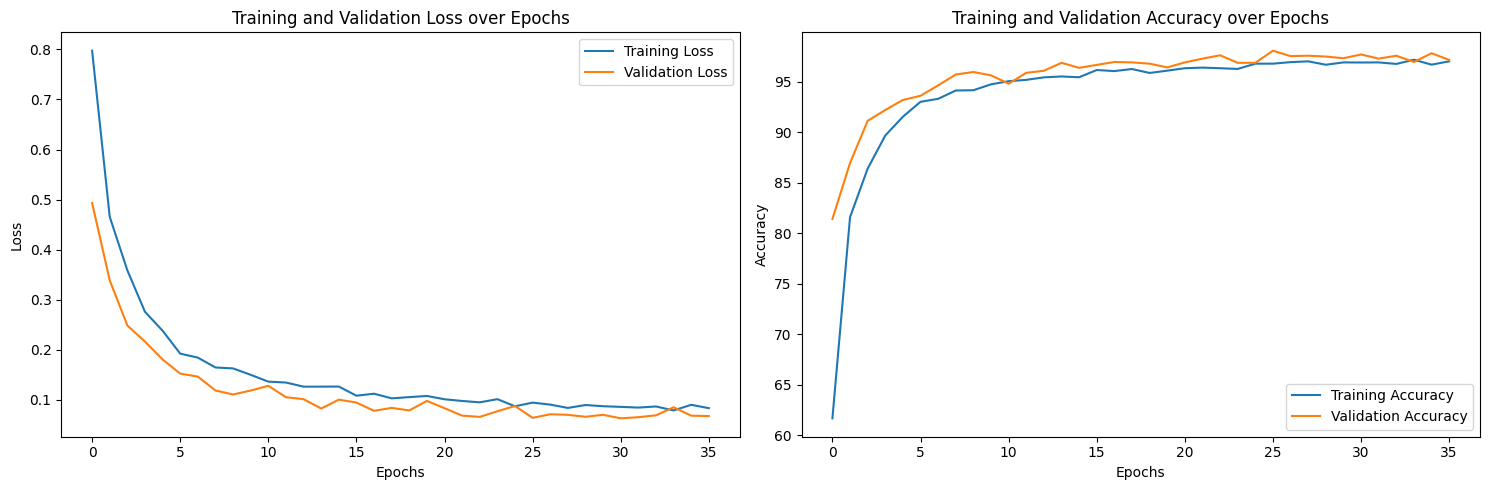

In [55]:
#Plot the result
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

⭐ Final Summary

Yes, there is overfitting, because:

Training loss keeps improving

Validation loss gets worse

Training accuracy reaches 100%

Validation accuracy stays lower

The two curves are not aligned anymore

But the overfitting is mild, not severe — and your model is still performing very well.

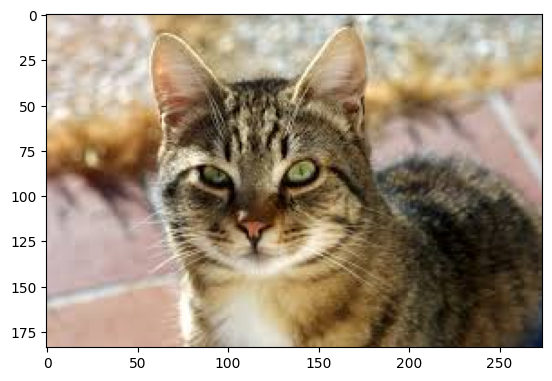

In [71]:
# 1- read image
# 2- Transform using transform object
# 3- predict through the model
# 4- inverse transform by label encoder

def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])

image = Image.open('cat1.jfif')
plt.imshow(image)
plt.show()


In [72]:
predict_image('cat1.jfif')

array(['cat'], dtype=object)